### Author: Julian Reed
#### Citations
* Article used as background info, particularly about wordclouds: https://towardsdatascience.com/a-beginners-guide-to-sentiment-analysis-in-python-95e354ea84f6
* Histogram background information: https://towardsdatascience.com/histograms-with-pythons-matplotlib-b8b768da9305
* Dataset: https://www.kaggle.com/snap/amazon-fine-food-reviews?select=Reviews.csv
* Data science ethics: https://www.freecodecamp.org/news/the-ethics-of-data-science/
* Word 2 vec implementation: https://www.geeksforgeeks.org/python-word-embedding-using-word2vec/

In [1]:
#Import all necesary libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
import nltk.corpus
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
from sklearn.linear_model import LogisticRegression

In [2]:
#import reviews dataset, convert it into a dataframe
df = pd.read_csv('Reviews.csv')
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Dataset Description (from kaggle.com): This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.

Features of this dataset, where `Score` will be eventually used to determine sentiment:
* `Id`: the id of each review, starting from one
* `ProductId`: the id of the product being reviewed
* `UserID`: the id of the user making the review
* `ProfileName`: the profile name of the user making the review
* `HelpfulnessNuermator`: the amount of people who found the review useful
* `HelpfulnessDenominator`: the total number of people who found the review either helpful or not
* `Score`: the user's rating of the product from 1 to 5, where 1 is the worst and 5 is the best
* `Time`: the timestamp when the review was made
* `Summary`: a brief summary of the review, derived from the `Text` column
* `Text`: the text of the review

This data was collected straight from Amazon's website. With that fact in mind, I believe that this dataset should be a good representation of many different groups of people, which would help the model be accurate no matter gender, race, age, etc., as Amazon's customer base is huge (although there are some small desperaties between groups, for example, people under 40 use Amazon more than people over 40). Since the reviews pretain to products, it is unlikely that racist, sexist or homophobic language will be used, and Amazon also has features to prevent against this language, so the problem of insensitive language should be largely resolved by itself.

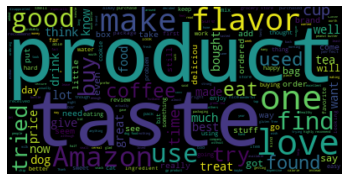

In [3]:
stopwords = set(STOPWORDS)
stopwords.update(["br", "href"])
textt = " ".join(review for review in df.Text)
wordcloud = WordCloud(stopwords=stopwords).generate(textt)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

One good way to visualize the data, especially for sentiment analysis, is to create a word cloud representing the text and the most common words. This word cloud, created using text from the `Text` feature of the dataset, shows that some of the most common words include "taste", "love", "product" and "make". These common words are logical considering the dataset is food reviews, and there doesn't appear to be any issues with this vital column. \
This step was inspired by this article: https://towardsdatascience.com/a-beginners-guide-to-sentiment-analysis-in-python-95e354ea84f6

Next, it is important to get a good understanding of the `score` feature and to resolve any problems with it, so that those scores can be used to create a `sentiment` feature, which will connect the words used in the summary of the review to a positive or negative sentiment.

In [4]:
df['Score'].value_counts()

5    363122
4     80655
1     52268
3     42640
2     29769
Name: Score, dtype: int64

<BarContainer object of 5 artists>

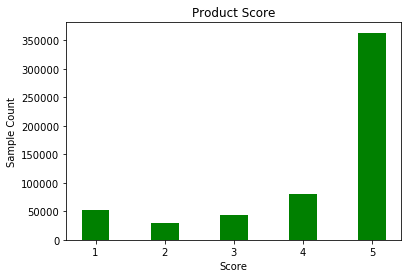

In [5]:
#Create a bar graph of product scores
fig = plt.figure(figsize = (6,4))
plt.title("Product Score")
plt.xlabel("Score")
plt.ylabel("Sample Count")
plt.bar(['1', '2', '3', '4', '5'], [52268, 29769, 42640, 80655, 363122], 
        color ='green', width = 0.4)

I think a good first step is creating a simple bar graph demonstrating the distribution of reviews by score. This shows that we have far more positive reviews (Score = 5 or 4) than negative (Score = 2 or 1), so this is something I need to keep in mind. That being said, each score has at least 25,000 samples, which is a good starting point for training my model later on.

In [6]:
df['Score'].describe()

count    568454.000000
mean          4.183199
std           1.310436
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: Score, dtype: float64

A description of the score column reinforces the bar graph's visualization of the difference in samples for each review score, as the average score is 4.18, showing that there were far more scores of 5 than anything else. Also, it seems that there aren't any missing samples or any glaring issues with the data, as the minimum is a flat 1.0 while the max is a flat 5.0, as expected.

Since the `Score` column looks good, I will now use it to create a `sentiment` column. In terms of classification, I will classify samples with scores of 4 and 5 as samples with positive sentiment, giving them a 1. I will repeat this process for samples with socres of 1 and 2, which have a negative sentiment (-1). I will remove samples with a neutral score (3), to make the data quicker to train and more accurate given the huge size of the dataset.

In [7]:
#Classify positive and negative words 
df = df[df['Score'] != 3]
df['sentiment'] = df['Score'].apply(lambda rating : +1 if rating > 3 else -1)
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,sentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,-1
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,-1
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,1


Now that the sentiment column has been added, I will take a look at the larger dataset and clean it up as necessary. First, I will remove punctuation from the text and summary columns, as punctuation would interfere with the vectorization process later on, and drop any null rows from both columns.

In [8]:
#Cleaning data
def remove_punctuation(text):
    final = "".join(u for u in text if u not in ("?", ".", ";", ":",  "!",'"'))
    return final
df = df.dropna(subset=['Text'])
df['Text'] = df['Text'].apply(remove_punctuation)
df = df.dropna(subset=['Summary'])
df['Summary'] = df['Summary'].apply(remove_punctuation)

Now that the most important columns are in the correct state, I will clean up the rest of the columns. First step: finding rows with null values.

In [9]:
#Find rows with missing data:
df[df.isnull().any(axis=1)]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,sentiment
25509,25510,B000LKZB4Y,A36BVYD0NT7Z0F,NaN,0,0,5,1314576000,These are the best mints and no aspartame or BHT,I was so shocked to find out that almost all g...,1
38874,38875,B000AYDGZ2,A36BVYD0NT7Z0F,NaN,2,3,1,1278374400,doesn't anyone care that they are putting BHT ...,I called Kellogg's to see why Special K red be...,-1
49800,49801,B000CRHQN0,A2LYFY32LXQDON,NaN,0,0,2,1282608000,They were melted and the chocolate had turned ...,We love these bars but i won't order them ship...,-1
67077,67078,B0006348H2,A2P0P67Y55SNOX,NaN,1,1,5,1314662400,Wheatgrass,Kitty seems to like this sprinkled on her food...,1
106550,106551,B001EQ5DG0,A1P500QXEG3IUZ,NaN,0,0,5,1326758400,Finally,"You cannot find this in the stores anymore, it...",1
137613,137614,B000CQE3HS,AGT3BYX5P9SLH,NaN,0,0,5,1324684800,awesome,i love them they are amazing I would eat them ...,1
163191,163192,B000CQID1A,AGT3BYX5P9SLH,NaN,0,0,5,1324684800,awesome,i love them they are amazing I would eat them ...,1
172462,172463,B001FA1L9I,AC9U70TRGPDGJ,NaN,0,0,5,1289520000,very good,came in proper packaging Have loved British H...,1
297275,297276,B007OXJM6E,A29D7XVSBCLFLD,NaN,0,0,1,1325203200,Burnt,The last SEVERAL time we bought this it tasted...,-1
306751,306752,B000RI1W8E,AGT3BYX5P9SLH,NaN,0,0,5,1324684800,awesome,i love them they are amazing I would eat them ...,1


It seems that the only column with null values is the `ProfileName` column. At this point, since the column isn't being used for anything, I think it would be fine just to drop it from the dataset. Actually, since the only columns that are going to be used for trianing and testing of the model are `Summary`and `sentiment`, I will actually drop the rest of the columns.

In [10]:
#Create a new dataframe from the necessary columns
#dfNew = df[['Summary','sentiment']]
#dfNew.head(50)
df.drop('Id', axis=1, inplace=True)
df.drop('ProductId', axis=1, inplace=True)
df.drop('UserId', axis=1, inplace=True)
df.drop('ProfileName', axis=1, inplace=True)
df.drop('HelpfulnessNumerator', axis=1, inplace=True)
df.drop('HelpfulnessDenominator', axis=1, inplace=True)
df.drop('Score', axis=1, inplace=True)
df.drop('Time', axis=1, inplace=True)
df.drop('Text', axis=1, inplace=True)
df.head(20)

,Summary,sentiment
0,Good Quality Dog Food,1
1,Not as Advertised,-1
2,Delight says it all,1
3,Cough Medicine,-1
4,Great taffy,1
5,Nice Taffy,1
6,Great Just as good as the expensive brands,1
7,"Wonderful, tasty taffy",1
8,Yay Barley,1
9,Healthy Dog Food,1


Now that the dataset has been fully modified to my needs, I will double check that the sentiment classification has been done correctly by creating wordclouds of both positive and negative words and creating a bar graph of the amount of samples for each sentiment. If everything was done correctly, then the outputted graphs and wordclouds should make sense given the sentiment.

In [11]:
# split df - positive and negative sentiment:
positive = df[df['sentiment'] == 1]
negative = df[df['sentiment'] == -1]

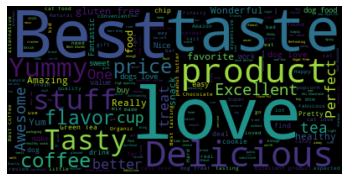

In [12]:
#Wordcloud of positive words
stopwords = set(STOPWORDS)
stopwords.update(["br", "href","good","great"]) 
## good and great removed because they were included in negative sentiment
pos = " ".join(review for review in positive.Summary)
wordcloud2 = WordCloud(stopwords=stopwords).generate(pos)
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

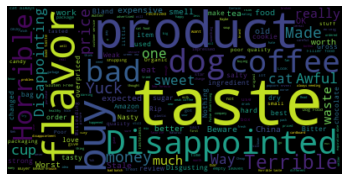

In [13]:
#wordcloud of negative words
neg = " ".join(review for review in negative.Summary)
wordcloud3 = WordCloud(stopwords=stopwords).generate(neg)
plt.imshow(wordcloud3, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud33.png')
plt.show()

In [14]:
df['sentiment'].value_counts()

 1    443777
-1     82012
Name: sentiment, dtype: int64

<BarContainer object of 2 artists>

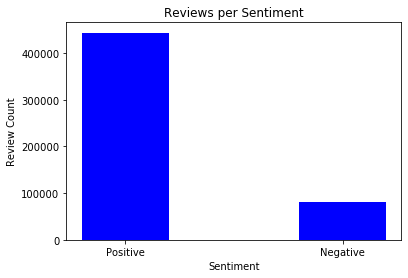

In [15]:
#review distribution
df['sentimentt'] = df['sentiment'].replace({-1 : 'negative'})
df['sentimentt'] = df['sentimentt'].replace({1 : 'positive'})
fig = plt.figure(figsize = (6,4))
plt.title("Reviews per Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Review Count")
plt.bar(['Positive', 'Negative'], [443777, 82012], 
        color ='blue', width = 0.4)

Everything looks good so far! The positive word cloud has words that you would expect to be positive, like 'best', 'delicious' and 'love', while the negative word cloud has words that are typically negative, such as 'terrible', 'awful', and 'horrible'. The graph confirms that there are far more positive samples than negative ones, as seen before with the distribution in the score column, but the total number appears to be the same, which is all expected. Next, I will create the train/test split for my model.

In [16]:
#Create train/test split
# random split train and test data
index = df.index
df['random_number'] = np.random.randn(len(index))
train = df[df['random_number'] <= 0.8]
test = df[df['random_number'] > 0.8]

Now that the train/test split has been created, use the training data to train the model. Also, the words need to be converted into numbers, so the summary data has to be vectorized.

In [17]:
#convert worsd into numbers, use word2vec here in future?
# count vectorizer:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
train_matrix = vectorizer.fit_transform(train['Summary'])
test_matrix = vectorizer.transform(test['Summary'])

In [18]:
#split target and independent variables
X_train = train_matrix
X_test = test_matrix
y_train = train['sentiment']
y_test = test['sentiment']

In [19]:
#Fit model, make preds
lr = LogisticRegression(max_iter = 500)
lr.fit(X_train,y_train)
predictions = lr.predict(X_test)

Now that the model has been trained, I will test the data and see how accurate the model is:

In [20]:
#print out confusion matrix and classificaion report
from sklearn.metrics import confusion_matrix,classification_report
new = np.asarray(y_test)
confusion_matrix(predictions,y_test)
print(classification_report(predictions,y_test))

              precision    recall  f1-score   support

          -1       0.66      0.83      0.74     13775
           1       0.98      0.94      0.96     97281

    accuracy                           0.93    111056
   macro avg       0.82      0.89      0.85    111056
weighted avg       0.94      0.93      0.93    111056



According to the above confusion matrix, the data model has 93% accuracy, which is pretty considering the size of the dataset. Next, I will use word2vec to determine the similarity between certain words.

In [21]:
#WORD 2 VEC
#necesary imports
from nltk.tokenize import sent_tokenize, word_tokenize
import gensim
from gensim.models import Word2Vec

In order to train the model, the text from the `Summary` column of the dataset must be converted into one big list, where each entry is a list, and the `data` list is really just a list of the summary from each column.

In [22]:
#convert each summary column into one big dataset
summary_strings = df['Summary'].tolist()
data = []
for i in range(len(summary_strings)):
    data.append(list(summary_strings[i].split(" ")))

Now that the data has been correctly formatted, I will use it to train a CBOW model and a Skip-Gram model:

In [23]:
#create CBOW model
cbow_model = gensim.models.Word2Vec(data, min_count = 1, window = 5)

#create Skip-Gram model
sg_model = gensim.models.Word2Vec(data, min_count = 1, window = 5, sg = 1)

In [24]:
#function to print similarity between words
def print_similarity(word1, word2, model = 'both'):
    if model == 'sg':
        print(f"Cosine similarity between {word1} and {word2} - Skip-gram: {sg_model.wv.similarity(word1, word2)}")
    
    elif model == 'cbow':
        print(f"Cosine similarity between {word1} and {word2} - CBOW: {cbow_model.wv.similarity(word1, word2)}")
        
    else:
        print(f"Cosine similarity between {word1} and {word2} - CBOW: {cbow_model.wv.similarity(word1, word2)}")
        print(f"Cosine similarity between {word1} and {word2} - Skip-gram: {sg_model.wv.similarity(word1, word2)}")

In [25]:
#test similarity between two words according to models
print_similarity('taffy', 'dog')
print_similarity('oatmeal', 'breakfast')
print(sg_model.wv.most_similar("breakfast"))

Cosine similarity between taffy and dog - CBOW: 0.015156205743551254
Cosine similarity between taffy and dog - Skip-gram: 0.4095982015132904
Cosine similarity between oatmeal and breakfast - CBOW: 0.577597975730896
Cosine similarity between oatmeal and breakfast - Skip-gram: 0.6738852858543396
[('anytime', 0.7696287631988525), ('on-the-go', 0.755964457988739), ('evening', 0.750426709651947), ('afternoon', 0.7477654814720154), ('low-calorie', 0.7364756464958191), ('comfort', 0.735952615737915), ('coffee/tea', 0.7359035611152649), ('dessert', 0.7315818667411804), ('pick-me-up', 0.7289500832557678), ('snack', 0.7268979549407959)]


Using the word2vec models I just created, I tested the similarity between two words which should have a low similarity, 'taffy' and 'dog' and also between two words which should have a high similarity, 'oatmeal' and 'breakfast'. As expected, 'taffy' and 'dog' have a low similarity, but 'oatmeal' and 'breakfast' don't have as high of a similarity as I originally expected. This could be a result of people using the word breakfast on a review about oatmeal, and therefore not using the word oatmeal in the review itself. This is proven by looking at the most similar words to 'breakfast', many of which could describe oatmeal, such as 'comfort', 'anytime' or 'ideal'. These results show that the model is a pretty good representation of the similarity between words and therefore fufils its purpose well.